In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys


sys.path.append("../functions")

from Utils import *
import scipy

%matplotlib inline
# %load_ext jupyter_black

# plt.style.use("../matplotlib_style.txt")
from Fitting import fit_for_all_subjects_parallel
from scipy.optimize import minimize
from Forward import forward_LL

In [3]:
raw_data = pd.read_csv("../data/twoArmedandit_with_confidence.csv")
# selecting usefull columns
data = raw_data[
    [
        "sub",
        "condition",
        "cresp",
        "resp",
        "cor",
        "cj",
        "phase",
        "trial",
        "trial_rev",
        "reward",
        "Lreward",
        "Hreward",
    ]
]
# excluding chance level subjects
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]

# selecting portion of data with proper task
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subjects))
]
subjects = lv_induction_data["sub"].unique()

In [25]:
def backward_distance_leaky(params, resps, rewards, confs):
    alpha = params[0]
    beta = params[1]

    lbound = params[2]
    hbound = params[3] * (5 - lbound) + lbound
    
    conf_multiplier = params[4]
        
    task_length = len(resps)
    resps_probabilities = np.zeros(task_length)
    Q = np.array([.5, .5])
    for t in range(task_length):
        choices_probability = softmax_func(Q, beta)
        resps_probabilities[t] = choices_probability[resps[t]]
        prediction_error = rewards[t] - Q[resps[t]]
        Q[resps[t]] = Q[resps[t]] + alpha * prediction_error

    model_confs = linear_transform_on_array(resps_probabilities, [0, 1], [lbound, hbound])
    prev_confs = np.zeros_like(model_confs)
    prev_confs[1:] = model_confs[:-1]
    
    changed_confs = conf_multiplier*model_confs + (1-conf_multiplier)*prev_confs

    dist = mean_square_distance(confs, changed_confs)
    
    return dist

def backward_fitting(dict_input):
    resps = dict_input["resp"]
    rewards = dict_input["reward"]
    confs = dict_input["cj"]
    n_fitting = dict_input["n_fitting"]
    params_ranges = dict_input["params_ranges"]
    min_dist = np.inf
    neg_LL = 0
    dist_seq = np.zeros(n_fitting)
    neg_LL_seq = np.zeros(n_fitting)
    for j in range(n_fitting):
        params0 = np.zeros(len(params_ranges))
        for p in range(len(params_ranges)):
            params0[p] = (np.random.uniform(*params_ranges[p]))
        fitting_result = minimize(backward_distance_leaky, x0=params0, args=(resps, rewards, confs), bounds=params_ranges)
        if fitting_result.success:
            if fitting_result.fun < min_dist:
                min_dist = fitting_result.fun
                fit_res = fitting_result.x
                neg_LL = forward_LL(fit_res, resps, rewards)
        dist_seq[j] = min_dist
        neg_LL_seq[j] = neg_LL
    return fit_res, neg_LL_seq[-1], dist_seq[-1]

In [27]:


params_ranges = [[0, 1], [0.01, 100], [1, 5], [0, 1], [0,1]]

n_fitting = 120
n_threads = 100

back_res = fit_for_all_subjects_parallel(
    params_ranges, n_threads, n_fitting, subjects, lv_induction_data, backward_fitting, scale=True
)
backward_df_leaky = make_df_after_fitting(
    back_res, ["alpha", "beta", "lbound", "bound_range", "conf_ml"], subjects
)
backward_df_leaky["hbound"] = (5 - backward_df_leaky["lbound"]) * (
    backward_df_leaky["bound_range"]
) + backward_df_leaky["lbound"]

backward_df_leaky.to_csv("../results/backward_leaky_df.csv")

In [28]:
def pval_symb(p):
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = "n.s"
    return sig_symbol

def comparison_plot(df, y_column, groups, titlestr="", s=[], y_list=[], h_list=[], legend="", y_label="",
                    var_df=pd.DataFrame()):
    

    for gr1, gr2 in zip(groups[:-1], groups[1:]):
        X_coords = np.array([df.query("model=='{}'".format(gr1)).x_idx,
                             df.query("model=='{}'".format(gr2)).x_idx])
        Y_coords = np.array([df.query("model=='{}'".format(gr1))[y_column],
                             df.query("model=='{}'".format(gr2))[y_column]])
        plt.plot(X_coords,
                 Y_coords,
                 color='gray',
                 alpha=.2)

        x_means = [df.query("model=='{}'".format(gr1)).x_idx.mean(), df.query("model=='{}'".format(gr2)).x_idx.mean()]
        y_means = [df.query("model=='{}'".format(gr1))[y_column].mean(),
                   df.query("model=='{}'".format(gr2))[y_column].mean()]
        plt.plot(x_means,
                 y_means,
                 marker='o',
                 linewidth=3, markersize=10, color="black")

    c = 0
    for gr1, gr2 in s:
        gr1_data = df.query("model=='{}'".format(gr1))
        gr2_data = df.query("model=='{}'".format(gr2))
        gr1_x_mean = gr1_data.x_idx.mean()
        gr2_x_mean = gr2_data.x_idx.mean()

        # stat, p = scipy.stats.ttest_ind(np.array(gr1_data[y_column]),np.array(gr2_data[y_column])).pvalue
        stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))
        print('Statistics={}, p={:.3e}'.format(stat, p))
        symb = pval_symb(p)
        y = y_list[c]
        h = h_list[c]
        plt.plot([gr1_x_mean, gr1_x_mean, gr2_x_mean, gr2_x_mean], [y, y + h, y + h, y], lw=1.5, c="k")
        plt.text((gr1_x_mean + gr2_x_mean) / 2, y + h, symb, ha='center', va='bottom', fontsize=16)
        c += 1

    gr_xticks_ls = []
    for gr in groups:
        plt.scatter(df.query("model=='{}'".format(gr)).x_idx,
                    df.query("model=='{}'".format(gr))[y_column],
                    label=gr, c=color_dict[gr])
        gr_mean = df.query("model=='{}'".format(gr)).x_idx.mean()
        gr_xticks_ls.append(gr_mean)

    if not var_df.empty:
        for i, row in var_df.iterrows():
            line_pos = df[(df['subject'] == row["sub"]) & (df['model'] == "Low-Meta")]["x_idx"].iloc[0]
            line_mean = df[(df['subject'] == row["sub"]) & (df['model'] == "Low-Meta")][y_column].iloc[0]
            y_min = line_mean - row["cor"]
            y_max = line_mean + row["cor"]
            plt.vlines(x=line_pos, ymin=y_min, ymax=y_max, colors="#fc5252", alpha=.2)
            plt.hlines(y=y_min, xmin=line_pos - 1, xmax=line_pos + 1, colors="#fc5252", alpha=.2)
            plt.hlines(y=y_max, xmin=line_pos - 1, xmax=line_pos + 1, colors="#fc5252", alpha=.2)

    plt.title(titlestr, fontsize=12)
    plt.ylabel(y_label, fontsize=22)
    plt.yticks(fontsize=19)
    plt.xticks(fontsize=22)
    ax = plt.gca()
    plt.xticks(gr_xticks_ls, groups)

    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)

    # hide x-axis
    # ax.get_xaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

In [29]:
color_dict = {"Backward": "#AA4499", "Backward-Leaky": "#882255"}

In [30]:
backward_df_leaky

,subject,alpha,beta,lbound,bound_range,conf_ml,LL,Confidence Distance,hbound
0,45628,1.000000,13.793070,4.681009,0.018222,0.213853,139.755791,0.741069,4.686822
1,45640,0.069717,100.000000,4.419089,0.225272,0.356034,310.150521,0.392511,4.549951
2,45664,0.004317,36.949200,1.261254,1.000000,0.568437,274.073600,1.530009,5.000000
3,45682,0.658202,57.955018,1.999409,0.698489,0.983204,460.252959,0.705768,4.095288
4,45745,1.000000,9.366839,4.137545,0.932173,0.673716,188.741889,0.429061,4.941502
5,45760,0.747970,23.764482,1.000000,0.927304,1.000000,82.892274,0.533329,4.709216
6,45763,0.989169,11.737870,1.766515,0.963598,0.709019,65.800819,0.923665,4.882295
7,45805,0.971499,1.857461,4.721638,1.000000,0.226054,242.992703,0.212404,5.000000
8,45829,1.000000,15.700473,1.018285,0.853612,0.862692,113.728765,0.730733,4.417127
9,45964,0.516229,30.024198,1.654768,0.779100,0.915689,166.088284,0.769085,4.261039


Statistics=11.0, p=4.467e-10


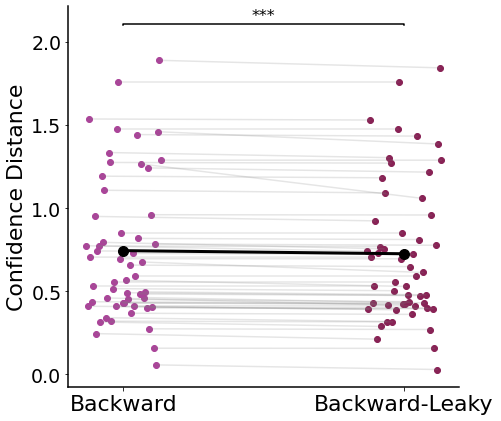

In [86]:
backward_df = pd.read_csv("../results/backward_df.csv", index_col= 0)
backward_df_leaky = pd.read_csv("../results/backward_leaky_df.csv")
backward_df_leaky["conf_ml"] = 1- backward_df_leaky["conf_ml"]

groups = ["Backward", "Backward-Leaky"]

params_df = merge_result_df([backward_df, backward_df_leaky], groups, 200, subjects)

plt.figure(figsize=(7, 7))

comparison_plot(
    params_df,
    "Confidence Distance",
    groups,
    "",
    [["Backward", "Backward-Leaky"]],
    [2.1],
    [0.01],
    y_label="Confidence Distance",
    legend="upper right",
)

(array([ 0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

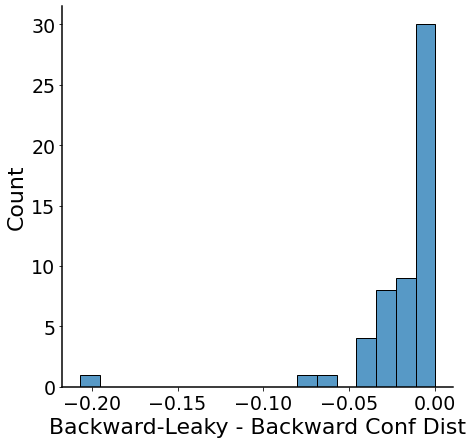

In [33]:
import seaborn 

temp = backward_df_leaky["Confidence Distance"] - backward_df["Confidence Distance"]

plt.figure(figsize=(7, 7))

seaborn.histplot(temp)
plt.ylabel("Count", fontsize=22)
plt.xlabel("Backward-Leaky - Backward Conf Dist", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)


Statistics=140.0, p=9.824e-05
Statistics=260.0, p=5.520e-05


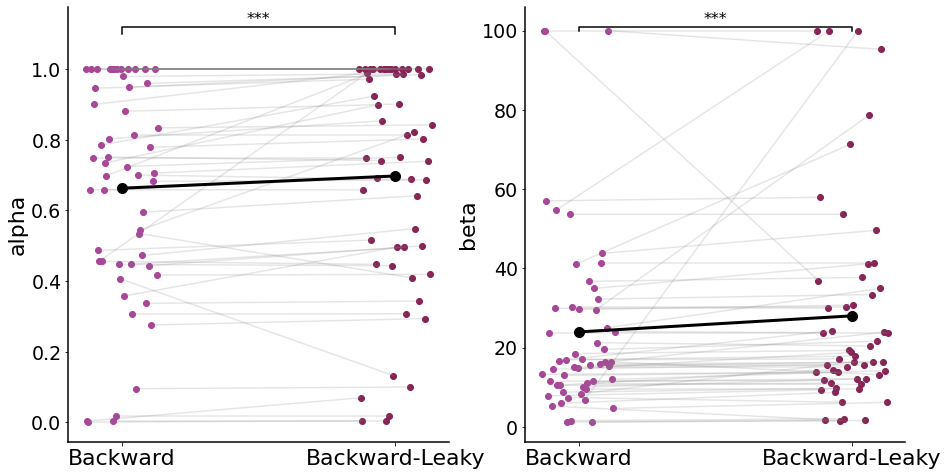

In [34]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
comparison_plot(
    params_df,
    "alpha",
    groups,
    "",
    [groups],
    [1.1],
    [0.02],
    y_label="alpha",
)
plt.subplot(1, 2, 2)
comparison_plot(
    params_df,
    "beta",
    groups,
    "",
    [groups],
    [100],
    [1],
    y_label="beta",
)

Statistics=132.0, p=1.097e-04
Statistics=467.0, p=1.478e-01


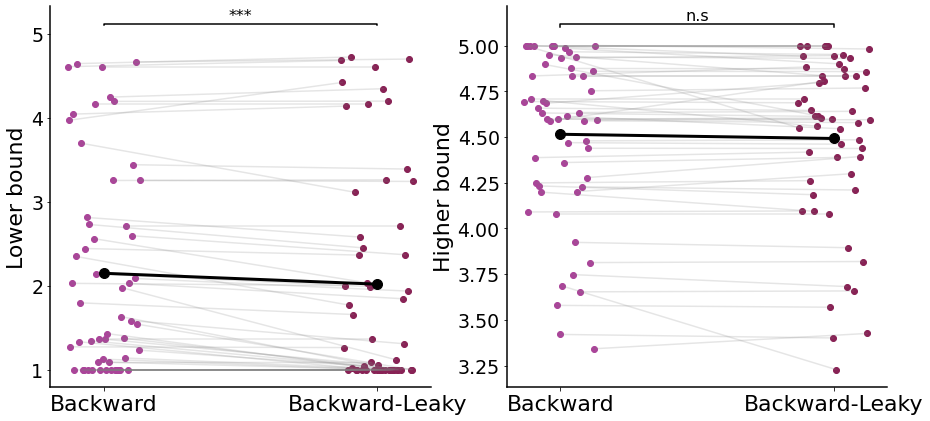

In [35]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
comparison_plot(
    params_df,
    "lbound",
    groups,
    "",
    [groups],
    [5.1],
    [0.02],
    y_label="Lower bound",
)
plt.subplot(1, 2, 2)
comparison_plot(
    params_df,
    "hbound",
    groups,
    "",
    [groups],
    [5.1],
    [0.02],
    y_label="Higher bound",
)

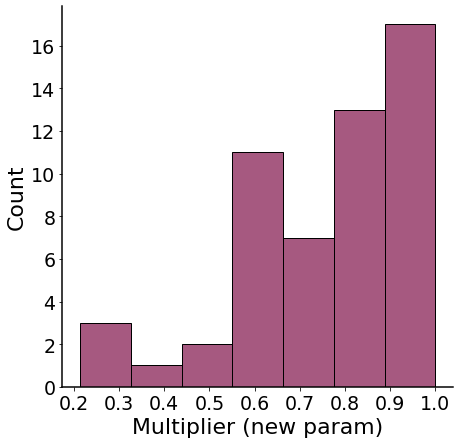

In [36]:
import seaborn 

temp = backward_df_leaky["conf_ml"]

plt.figure(figsize=(7, 7))

seaborn.histplot(temp, color=  "#882255")
plt.ylabel("Count", fontsize=22)
plt.xlabel("Multiplier (new param)", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)

plt.show()

In [58]:
from Forward import simulate_with_params, simulate_with_params_one
import random

seed = 21
random.seed(seed)
np.random.seed(seed)

backward_df = pd.read_csv("../results/backward_df.csv", index_col= 0)
forward_df = pd.read_csv("../results/forward_df.csv")

backward_leaky_simulation_df = simulate_with_params(backward_df_leaky, lv_induction_data, subjects, n= 200)
# forward_simulation_df = pd.read_csv("../results/forward_simulation_df.csv")
# backward_simulation_df = pd.read_csv("../results/backward_simulation_df.csv")
forward_simulation_df = simulate_with_params(forward_df, lv_induction_data, subjects, n= 200)
backward_simulation_df = simulate_with_params(backward_df, lv_induction_data, subjects, n= 200)

In [61]:
backward_leaky_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
forward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
backward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)

forward_avg_df = (
    forward_simulation_df.groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)
backward_avg_df = (
    backward_simulation_df.groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)
backward_leaky_df = (
    backward_leaky_simulation_df.groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)


backward_avg_df["MetaRL"] = backward_avg_df["cor"]/forward_avg_df["cor"]
backward_leaky_df["MetaRL"] =  backward_leaky_df["cor"]/forward_avg_df["cor"]

avg_df = merge_result_df(
    [backward_avg_df, backward_leaky_df], groups, 200, subjects
)
avg_df.rename(
    columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"},
    inplace=True,
)

Statistics=675.5, p=5.640e-01


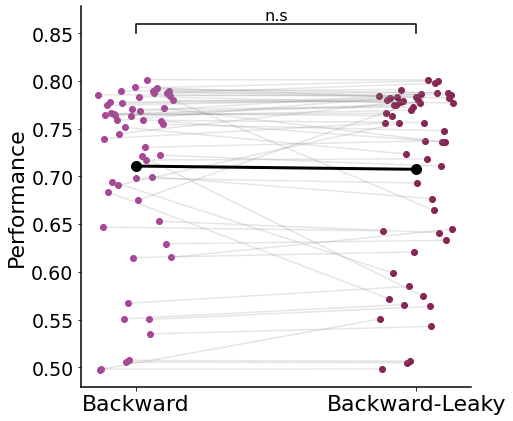

In [62]:
plt.figure(figsize=(7, 7))

comparison_plot(
    avg_df,
    "accuracy",
    groups,
    "",
    [groups],
    [.85, 1, 1.05],
    [0.01, 0.01, 0.02],
    y_label="Performance",
)

Statistics=670.0, p=5.325e-01


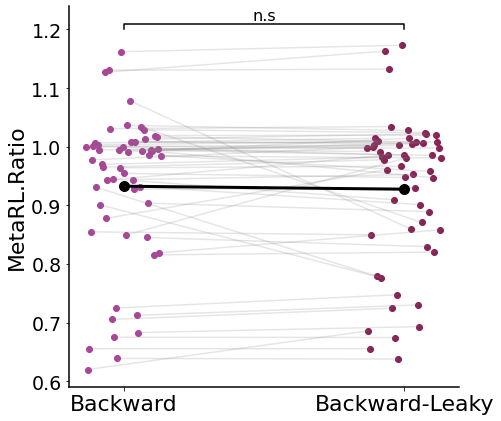

In [63]:
plt.figure(figsize=(7, 7))

comparison_plot(
    avg_df,
    "MetaRL",
    groups,
    "",
    [groups],
    [1.2, 1, 1.05],
    [0.01, 0.01, 0.02],
    y_label="MetaRL.Ratio",
)

In [64]:
backward_with_params = pd.merge(backward_leaky_df, backward_df_leaky, on =["subject"])
backward_with_params

,subject,reward,cor,cj,MetaRL,model_x,x_idx_x,alpha,beta,lbound,bound_range,conf_ml,LL,Confidence Distance,hbound,model_y,x_idx_y
0,45628,0.556644,0.784112,4.686047,0.998567,Backward-Leaky,201,1.000000,13.793070,4.681009,0.018222,0.213853,139.755791,0.741069,4.686822,Backward-Leaky,201
1,45640,0.510990,0.550650,4.531359,0.686093,Backward-Leaky,202,0.069717,100.000000,4.419089,0.225272,0.356034,310.150521,0.392511,4.549951,Backward-Leaky,202
2,45664,0.500118,0.498200,3.142799,0.655645,Backward-Leaky,203,0.004317,36.949200,1.261254,1.000000,0.568437,274.073600,1.530009,5.000000,Backward-Leaky,203
3,45682,0.531847,0.642938,4.020437,0.849744,Backward-Leaky,204,0.658202,57.955018,1.999409,0.698489,0.983204,460.252959,0.705768,4.095288,Backward-Leaky,204
4,45745,0.551459,0.755925,4.749399,0.999372,Backward-Leaky,205,1.000000,9.366839,4.137545,0.932173,0.673716,188.741889,0.429061,4.941502,Backward-Leaky,205
5,45760,0.554053,0.766012,4.416162,1.002634,Backward-Leaky,206,0.747970,23.764482,1.000000,0.927304,1.000000,82.892274,0.533329,4.709216,Backward-Leaky,206
6,45763,0.556278,0.780188,4.315125,1.014218,Backward-Leaky,207,0.989169,11.737870,1.766515,0.963598,0.709019,65.800819,0.923665,4.882295,Backward-Leaky,207
7,45805,0.514473,0.571975,4.866287,0.779098,Backward-Leaky,208,0.971499,1.857461,4.721638,1.000000,0.226054,242.992703,0.212404,5.000000,Backward-Leaky,208
8,45829,0.559315,0.781787,4.027102,1.009018,Backward-Leaky,209,1.000000,15.700473,1.018285,0.853612,0.862692,113.728765,0.730733,4.417127,Backward-Leaky,209
9,45964,0.553729,0.763525,4.041694,0.991784,Backward-Leaky,210,0.516229,30.024198,1.654768,0.779100,0.915689,166.088284,0.769085,4.261039,Backward-Leaky,210


In [42]:
from matplotlib.legend_handler import HandlerTuple

def plot_regression_df(df,x, y, color, pos_x, pos_y, xlabel, ylabel):
    

    res = scipy.stats.pearsonr(df[x], df[y])

    stat_fwd_lr, pval= res 
    r_low, r_high = res.confidence_interval(.95)
    print("(p = {:.2e}, r = {:.2f},ci = [{:.2f},{:.2f}])".format(pval, stat_fwd_lr,r_low,r_high))

    seaborn.regplot(data=df, x=x, y=y, color= color, label= "Forwarad Model")

    plt.ylabel(ylabel, fontsize=22)
    plt.xlabel(xlabel, fontsize=22)

    ax = plt.gca()
    # hide x-axis
    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(1.5)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)
    plt.text(pos_x, pos_y, "p = {:.2e} \n r = {:.2f}".format(pval, stat_fwd_lr), fontsize=18)
    

(p = 7.14e-02, r = 0.25,ci = [-0.02,0.48])


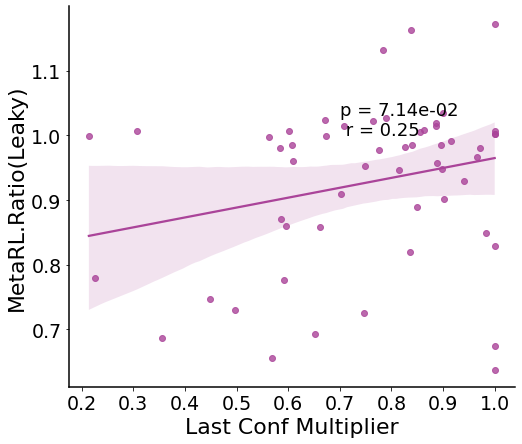

In [65]:
plt.figure(figsize=(8,7))

plot_regression_df(backward_with_params, "conf_ml", "MetaRL", "#AA4499",0.7, 1, "Last Conf Multiplier", "MetaRL.Ratio(Leaky)")

(p = 1.69e-01, r = 0.19,ci = [-0.08,0.44])


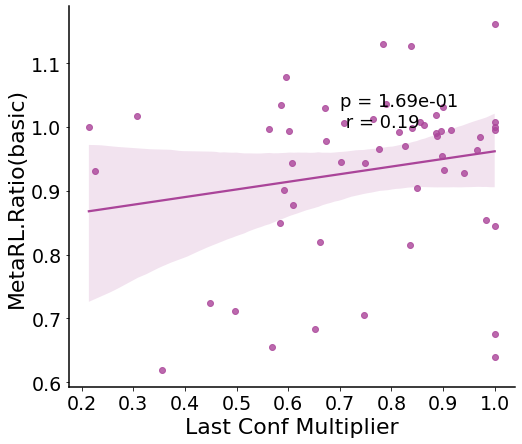

In [66]:
plt.figure(figsize=(8,7))


backward_with_params = pd.merge(backward_avg_df, backward_df_leaky, on =["subject"])

plot_regression_df(backward_with_params, "conf_ml", "MetaRL", "#AA4499",0.7, 1, "Last Conf Multiplier", "MetaRL.Ratio(basic)")

(p = 9.93e-02, r = 0.23,ci = [-0.04,0.47])


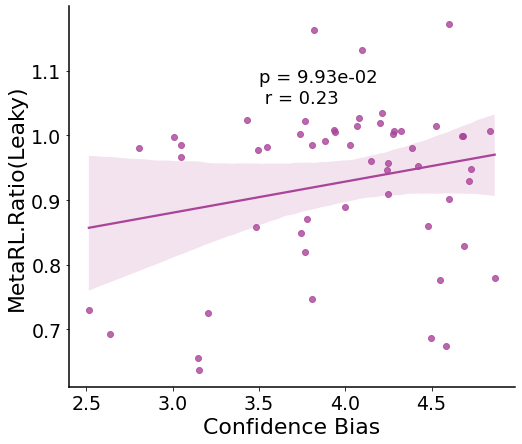

In [67]:
plt.figure(figsize=(8,7))
emp_metrics_df = lv_induction_data.groupby("sub").apply(lambda x: pd.Series({
    "emp_acc": x["cor"].mean(),
    "emp_cj": x["cj"].mean()
})).reset_index().rename(columns={"sub": "subject"})

backward_with_params = pd.merge(backward_leaky_df, backward_df_leaky, on =["subject"])
backward_with_params = pd.merge(backward_with_params, emp_metrics_df, on =["subject"])

plot_regression_df(backward_with_params, "emp_cj", "MetaRL", "#AA4499",3.5, 1.05, "Confidence Bias", "MetaRL.Ratio(Leaky)")

(p = 9.60e-03, r = 0.35,ci = [0.09,0.56])


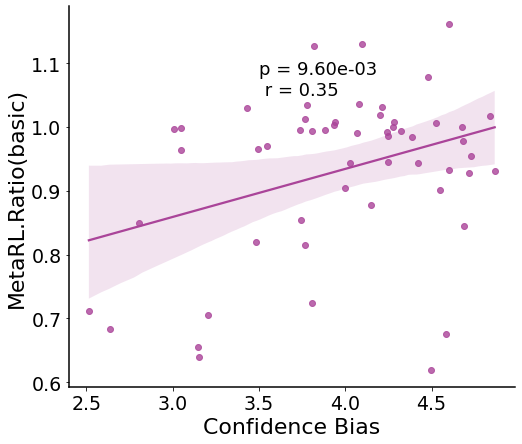

In [68]:
plt.figure(figsize=(8,7))
emp_metrics_df = lv_induction_data.groupby("sub").apply(lambda x: pd.Series({
    "emp_acc": x["cor"].mean(),
    "emp_cj": x["cj"].mean()
})).reset_index().rename(columns={"sub": "subject"})

backward_with_params = pd.merge(backward_df, backward_avg_df, on =["subject"])
backward_with_params = pd.merge(backward_with_params, emp_metrics_df, on =["subject"])

plot_regression_df(backward_with_params, "emp_cj", "MetaRL", "#AA4499",3.5, 1.05, "Confidence Bias", "MetaRL.Ratio(basic)")

In [69]:
import statsmodels.api as sm
autocorrelations = []
lags = []
subject_cl = []
for sub in subjects:
    subject_data = lv_induction_data[lv_induction_data["sub"] == sub]
    acf = sm.tsa.acf(subject_data["cj"])
    autocorrelations.extend(acf)
    lags.extend(np.arange(len(acf)))
    subject_cl.extend([sub]*len(acf))
auto_corrleation_df = pd.DataFrame(zip(subject_cl,lags, autocorrelations), columns=["subject","lags", "acf"])

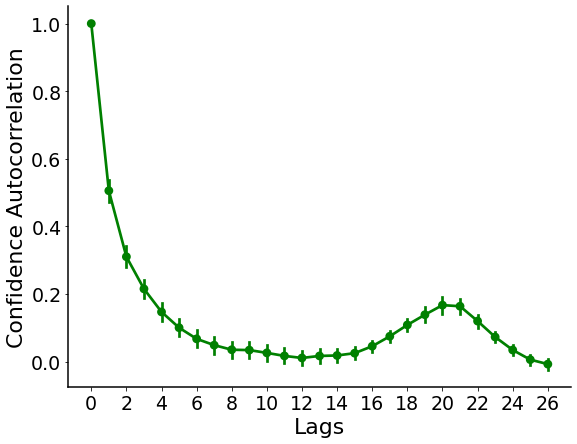

In [70]:
plt.figure(figsize=(9, 7))

seaborn.pointplot(data = auto_corrleation_df, x = "lags", y= "acf", color="green", errorbar="se")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


plt.xticks(fontsize=19)


plt.yticks(fontsize=19)


plt.xlabel("Lags", fontsize=22)
plt.ylabel("Confidence Autocorrelation", fontsize=22)

plt.locator_params(axis='x', nbins=15)


plt.show()

(p = 7.45e-04, r = 0.45,ci = [0.20,0.64])


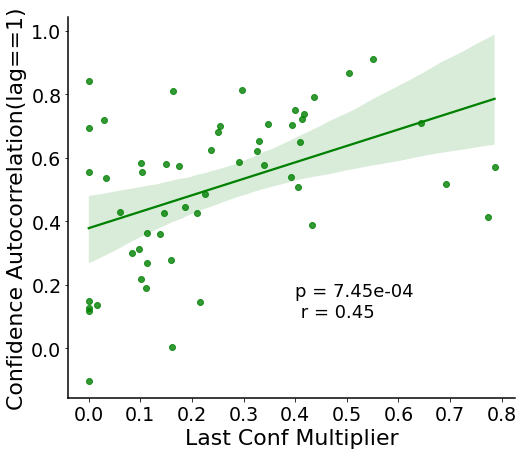

In [87]:
auto_corrleation_lag_1 = auto_corrleation_df[auto_corrleation_df["lags"] == 1]
backward_df_auto = pd.merge(backward_df_leaky, auto_corrleation_lag_1, on =["subject"])
plt.figure(figsize=(8,7))

plot_regression_df(backward_df_auto, "conf_ml", "acf", "green",0.4, .1, "Last Conf Multiplier", "Confidence Autocorrelation(lag==1)")

(p = 9.57e-01, r = -0.01,ci = [-0.27,0.26])


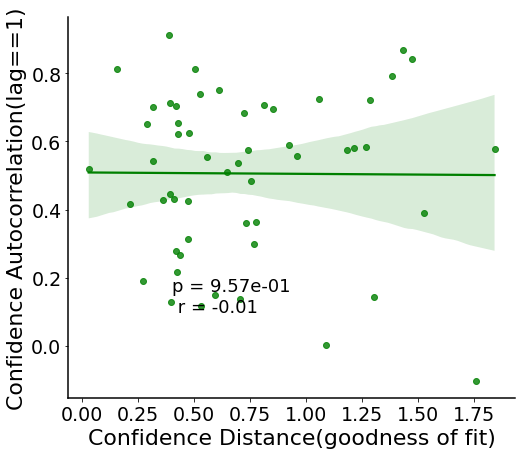

In [72]:
plt.figure(figsize=(8,7))

plot_regression_df(backward_df_auto, "Confidence Distance", "acf", "green",0.4, .1, "Confidence Distance(goodness of fit)", "Confidence Autocorrelation(lag==1)")



(p = 2.36e-02, r = -0.31,ci = [-0.54,-0.04])


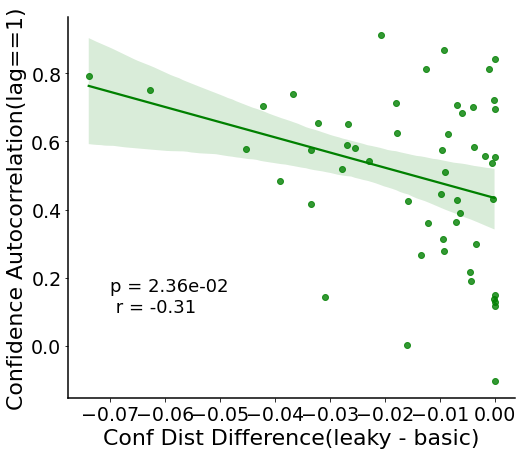

In [85]:
plt.figure(figsize=(8,7))

both_back  = pd.merge(backward_df_leaky, backward_df, on =["subject"])
both_back["diff_conf_dist"] = both_back["Confidence Distance_x"] - both_back["Confidence Distance_y"]

backward_df_auto2 = pd.merge(both_back, auto_corrleation_lag_1, on =["subject"])
backward_df_auto2 = backward_df_auto2[backward_df_auto2["diff_conf_dist"] > -.2]

plot_regression_df(backward_df_auto2, "diff_conf_dist", "acf", "green",-0.07, .1, "Conf Dist Difference(leaky - basic)", "Confidence Autocorrelation(lag==1)")



(p = 6.34e-01, r = 0.07,ci = [-0.21,0.33])


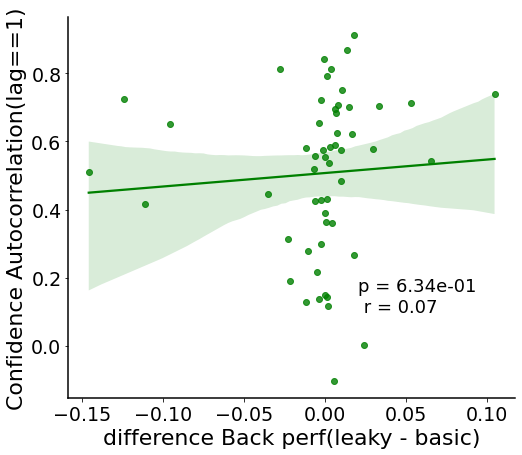

In [74]:
plt.figure(figsize=(8,7))

both_back_avg  = pd.merge(backward_leaky_df, backward_avg_df, on =["subject"])
both_back_avg["diff_perf"] = both_back_avg["cor_x"] - both_back_avg["cor_y"]

backward_auto_avg = pd.merge(both_back_avg, auto_corrleation_lag_1, on =["subject"])
plot_regression_df(backward_auto_avg, "diff_perf", "acf", "green",.02, .1, "difference Back perf(leaky - basic)", "Confidence Autocorrelation(lag==1)")



(p = 9.93e-02, r = 0.23,ci = [-0.04,0.47])
(p = 7.45e-04, r = 0.45,ci = [0.20,0.64])


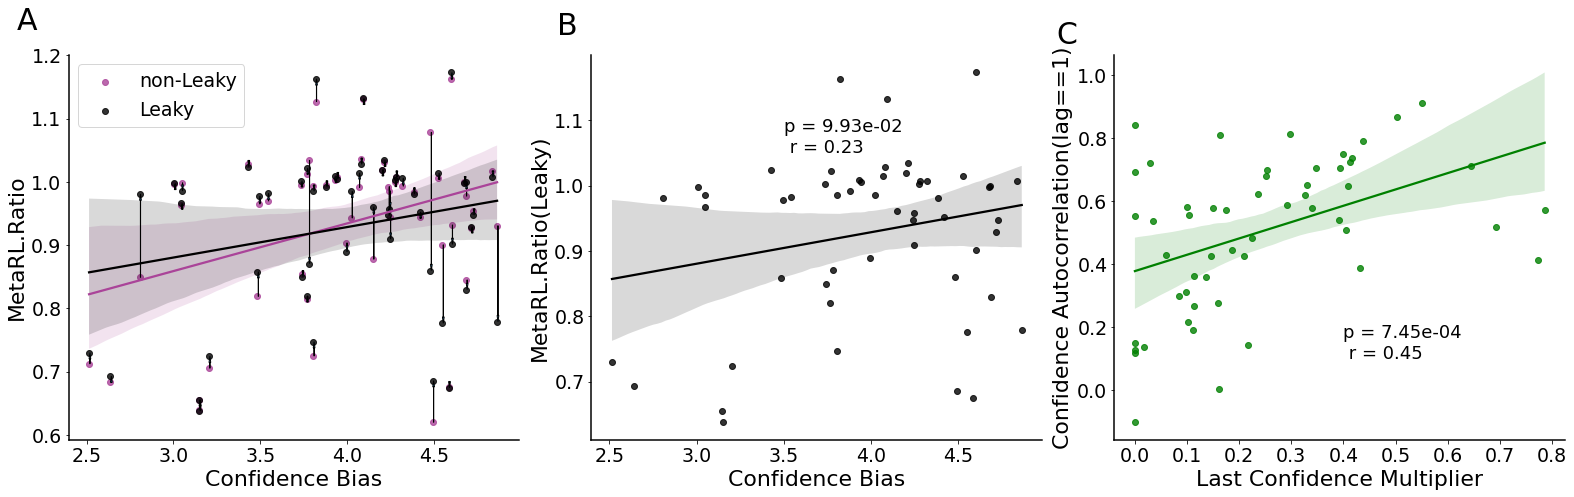

In [128]:
def plot_regression_df2(df,x, y, color, pos_x, pos_y, xlabel, ylabel, label):
    

    res = scipy.stats.pearsonr(df[x], df[y])

    stat_fwd_lr, pval= res 
    r_low, r_high = res.confidence_interval(.95)

    seaborn.regplot(data=df, x=x, y=y, color= color, label = label)

    plt.ylabel(ylabel, fontsize=22)
    plt.xlabel(xlabel, fontsize=22)

    ax = plt.gca()
    # hide x-axis
    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(1.5)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)

plt.figure(figsize=(22, 7))
plt.subplot(1,3,1)
plt.text(2.1, 1.24, "A", fontsize=30)


mrl_avg_basic = pd.merge(backward_avg_df, emp_metrics_df, on =["subject"])
mrl_avg_leaky = pd.merge(backward_leaky_df, emp_metrics_df, on =["subject"])


plot_regression_df2(mrl_avg_basic, "emp_cj", "MetaRL", "#AA4499",3.5, 1.05, "Confidence Bias", "MetaRL.Ratio", "non-Leaky")
plot_regression_df2(mrl_avg_leaky, "emp_cj", "MetaRL", "k",3.5, 1.05, "Confidence Bias", "MetaRL.Ratio", "Leaky")

plt.legend()
plt.rc('legend',fontsize=19) # using a size in points

avg_confs =[]
for sub in subjects:
    basic_data = mrl_avg_basic[mrl_avg_basic["subject"] ==sub].iloc[0]
    leaky_data = mrl_avg_leaky[mrl_avg_basic["subject"] ==sub].iloc[0]
    x = basic_data["emp_cj"]
    y = basic_data["MetaRL"]
    y2 = leaky_data["MetaRL"]
    dy = y2 - y
    plt.arrow(x+.005,y,0,dy, head_width = .01, head_length = .01, length_includes_head = True)


plt.subplot(1,3,2)
plt.text(2.2, 1.23, "B", fontsize=30)

emp_metrics_df = lv_induction_data.groupby("sub").apply(lambda x: pd.Series({
    "emp_acc": x["cor"].mean(),
    "emp_cj": x["cj"].mean()
})).reset_index().rename(columns={"sub": "subject"})

backward_with_params = pd.merge(backward_leaky_df, backward_df_leaky, on =["subject"])
backward_with_params = pd.merge(backward_with_params, emp_metrics_df, on =["subject"])

plot_regression_df(backward_with_params, "emp_cj", "MetaRL", "k",3.5, 1.05, "Confidence Bias", "MetaRL.Ratio(Leaky)")

plt.subplot(1,3,3)
plt.text(-.15, 1.1, "C", fontsize=30)

plot_regression_df(backward_df_auto, "conf_ml", "acf", "green",0.4, .1, "Last Confidence Multiplier", "Confidence Autocorrelation(lag==1)")    

plt.savefig("../figs/Leaky_model.png", dpi=400, bbox_inches='tight')

plt.tight_layout()
plt.show()

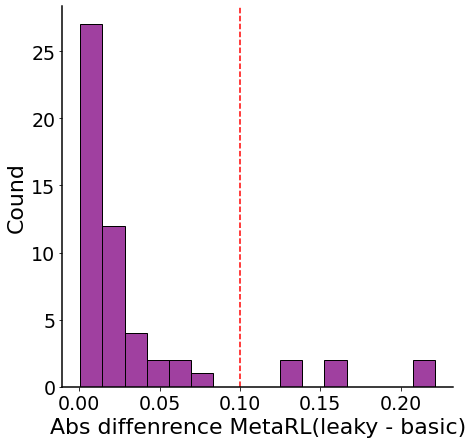

In [54]:
import seaborn 

temp = np.abs(both_back_avg["MetaRL_x"] - both_back_avg["MetaRL_y"])
both_back_avg["MetaRL_diff"] = np.abs(both_back_avg["MetaRL_x"] - both_back_avg["MetaRL_y"])

plt.figure(figsize=(7, 7))

seaborn.histplot(temp, color=  "purple")
plt.ylabel("Cound", fontsize=22)
plt.xlabel("Abs diffenrence MetaRL(leaky - basic)", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.axvline(.10, linestyle = "--", c= "red")

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)

plt.show()

In [55]:
subjects_to_remove = both_back_avg[both_back_avg["MetaRL_diff"] >.1].subject.to_numpy()
subjects_to_remove

array([45805, 46024, 46489, 46555, 46633, 46822])

(p = 2.42e-02, r = 0.32,ci = [0.04,0.56])
(p = 3.07e-02, r = 0.31,ci = [0.03,0.55])


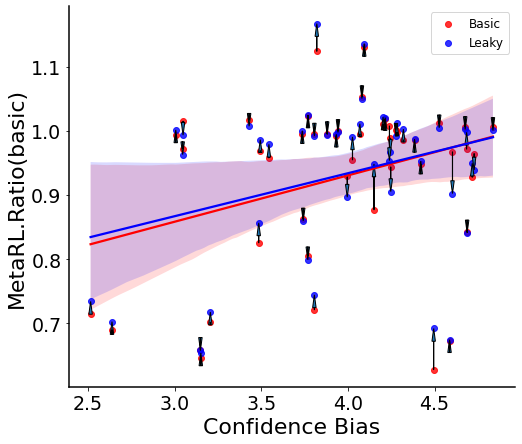

In [56]:
plt.figure(figsize=(8,7))


def plot_regression_df2(df,x, y, color, pos_x, pos_y, xlabel, ylabel, label):
    

    res = scipy.stats.pearsonr(df[x], df[y])

    stat_fwd_lr, pval= res 
    r_low, r_high = res.confidence_interval(.95)
    print("(p = {:.2e}, r = {:.2f},ci = [{:.2f},{:.2f}])".format(pval, stat_fwd_lr,r_low,r_high))


    seaborn.regplot(data=df, x=x, y=y, color= color, label = label)

    plt.ylabel(ylabel, fontsize=22)
    plt.xlabel(xlabel, fontsize=22)

    ax = plt.gca()
    # hide x-axis
    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(1.5)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)


mrl_avg_basic = pd.merge(backward_avg_df, emp_metrics_df, on =["subject"])
mrl_avg_leaky = pd.merge(backward_leaky_df, emp_metrics_df, on =["subject"])

mrl_avg_basic = mrl_avg_basic[~mrl_avg_basic['subject'].isin(subjects_to_remove)]
mrl_avg_leaky = mrl_avg_leaky[~mrl_avg_leaky['subject'].isin(subjects_to_remove)]


plot_regression_df2(mrl_avg_basic, "emp_cj", "MetaRL", "red",3.5, 1.05, "Confidence Bias", "MetaRL.Ratio(basic)", "Basic")
plot_regression_df2(mrl_avg_leaky, "emp_cj", "MetaRL", "blue",3.5, 1.05, "Confidence Bias", "MetaRL.Ratio(basic)", "Leaky")

plt.legend()
plt.rc('legend',fontsize=12) # using a size in points

avg_confs =[]
for sub in mrl_avg_leaky["subject"]:
    basic_data = mrl_avg_basic[mrl_avg_basic["subject"] ==sub].iloc[0]
    leaky_data = mrl_avg_leaky[mrl_avg_basic["subject"] ==sub].iloc[0]
    x = basic_data["emp_cj"]
    y = basic_data["MetaRL"]
    y2 = leaky_data["MetaRL"]
    dy = y2 - y
    plt.arrow(x,y,0,dy, head_width = .02, head_length = .02, length_includes_head = True)



plt.show()

In [140]:
mrl_avg_basic[mrl_avg_basic['subject'].isin(subjects_to_remove)]

,subject,reward,cor,cj,MetaRL,model,x_idx,emp_acc,emp_cj


In [141]:
subjects_to_remove

array([ 7, 10, 25, 28, 31, 39])